# GRID FOR PDX PROJECT

In [1]:
from PIL import Image, ImageFile
from PIL import ImageFont, ImageDraw
import pandas as pd
from os.path import join, isfile
from os import listdir
import numpy as np
import pysam

import sys

In [61]:
def highlight(img, coords, fill, width=5):
    draw = ImageDraw.Draw(img, "RGBA")
    draw.rectangle(coords, fill=fill)
    return img


def centered_pos(draw, x, y, txt, font, axis):
    tx, ty = draw.textsize(txt, font=font)
    if axis == "x":
        cx = x - tx / 2
        cy = y
    elif axis == "y":
        cx = x
        cy = y - ty / 2
    else:
        cx = x - tx / 2
        cy = y - ty / 2
    return (cx, cy)


def draw_labels(labels, positions, img, centering_axis=""):
    font_size = 40
    global_font = "/home/varelad/dash/LiberationSans-Regular.ttf"
    font = ImageFont.truetype(global_font, font_size, encoding="unic")
    for label, pos in zip(labels, positions):
        draw = ImageDraw.Draw(img)
        if centering_axis:
            draw.text(
                centered_pos(draw, pos[0], pos[1], label, font, centering_axis),
                label,
                fill="black",
                font=font,
            )
        else:
            draw.text((pos[0], pos[1]), label, fill="black", font=font)
    return img

def callers_color(sample_id, name_sv, df_out):
    list_svs = df_out["name"].tolist()
    index_sv = list_svs.index(name_sv)
    callers = df_out["callers"].tolist()
    callers_sv = callers[index_sv]
    called = sample_id in callers_sv
    return called


def create_imagen(outdir, rows_show, selected_svs, df_out, df_path, dict_annotation):
    columns_show = ["CIRCOS PLOT"] + selected_svs
    subset = df_path.loc[rows_show, columns_show]
    img_table = subset
    grid_size = 1000
    margin = 1 / 5
    margin = int(grid_size * margin)
    theight = grid_size * img_table.shape[0] + margin
    twidth = grid_size * img_table.shape[1] + margin
    mergedImg = Image.new("RGB", (twidth, theight), "white")
    for (i, j) in np.ndindex(img_table.shape):
        y, x = (i * grid_size + margin, j * grid_size + margin)
        mergedImg.paste(
            Image.open(img_table.iloc[i, j]).resize((grid_size, grid_size)), (x, y)
        )
        if j == 0:
            continue
        else:
            called = callers_color(img_table.index[i], img_table.columns[j], df_out)
        if called:
            mergedImg = highlight(
                mergedImg,
                [(x, y), (x + grid_size, y + grid_size)],
                (240, 215, 215, 100),
            )
        else:
            mergedImg = highlight(
                mergedImg, [(x, y), (x + grid_size, y + grid_size)], (180, 216, 230, 80)
            )
    annot = [dict_annotation.get(key) for key in selected_svs]
    labels = ["\n".join((label, annot)) for (label, annot) in zip(selected_svs, annot)]
    labels_circos = ["CIRCOS PLOT"] + labels
    positions = [
        (margin + i * grid_size + grid_size / 2, margin / 2)
        for i in range(len(labels_circos))
    ]
    mergedImg = draw_labels(labels_circos, positions, mergedImg, "xy")
    return mergedImg


In [62]:
def get_df_full(outdir, samples_ids):
    """Get a dataframe with ALL the information about the variants."""
#     with open(join(outdir, "names.txt")) as n:
#         list_names = n.readlines()
#     names = [word.strip() for word in list_names]
    columns_df = (
        [
            "svs",
            "chr1",
            "start1",
            "end1",
            "chr2",
            "start2",
            "end2",
            "name",
            "score",
            "strand1",
            "strand2",
            "type",
            "annot",
        ]
        + ["COV {}".format(sample_id) for sample_id in samples_ids]
        + ["callers"]
    )
    svs_table = join(outdir, "merged_svs_annot.tsv")
    df_in = pd.read_csv(svs_table, sep="\t", header=None, names=columns_df)
#     df_in.insert(0, "names_files", names)
    df_full = df_in
    return df_full


# FULL TABLE WITHOUT NAMES OF FILES


In [69]:
outdir="/home/varelad/outdir709"
samples_ids=["I-H-134709-N1-1-D1-1", "I-H-134709-T1-1-D1-1","I-H-134709-T2-1-D1-1", "I-H-134709-T3-1-D1-1","I-H-134709-T4-1-D1-1"]
df_out=get_df_full(outdir, samples_ids)

# IF PDX ARGUMENTS (ONE_BAM AND PDX_FILTERS)

In [70]:
def filtered(outdir):
    table_filtered = join(outdir,  "filtered_table.tsv")
    df = pd.read_csv(table_filtered, sep="\t", header=None)
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #data less the header row
    df.columns = new_header
    indexes=df[df.columns[0]]
    table = df.set_index(indexes).iloc[:,1:]  #first columns as index
    cols=indexes.tolist()
    return cols, table

# FILTERED TABLE

In [71]:
svs, table = filtered(outdir)
df_out_filt = df_out[df_out["name"].isin(svs)]
df_out_filt

,svs,chr1,start1,end1,chr2,start2,end2,name,score,strand1,strand2,type,annot,COV I-H-134709-N1-1-D1-1,COV I-H-134709-T1-1-D1-1,COV I-H-134709-T2-1-D1-1,COV I-H-134709-T3-1-D1-1,COV I-H-134709-T4-1-D1-1,callers
3,<SV> DUP DUP(2:113993501-2:113994020),2,113993500,113993501,2,113994019,113994020,DUP(2:113993501-2:113994020),100,-,+,DUP,PAX8(ONC):intron8>>PAX8(ONC):intron8,"(113L, 95L)","(222L, 240L)","(216L, 189L)","(165L, 159L)","(402L, 337L)","['I-H-134709-T1-1-D1-1', 'I-H-134709-T4-1-D1-1']"
18,<SV> TRA TRA(12:12036072-15:88501357),12,12036071,12036072,15,88501356,88501357,TRA(12:12036072-15:88501357),100,+,+,TRA,ETV6(TSG):intron5>>NTRK3(ONC):intron12,"(674L, 0L)","(1447L, 326L)","(1171L, 99L)","(1062L, 256L)","(1040L, 448L)","['I-H-134709-T2-1-D1-1', 'I-H-134709-T1-1-D1-1..."


# ADD NAMES OF FILES

In [76]:
def add names_files(outdir):
    path=join(outdir, samples_ids[0], "snapshots")
allfiles = [f for f in listdir(path) if isfile(join(path, f))]    
allfiles.remove('igvbatch_0.txt')
files = [i.split(".")[0] for i in allfiles]
files
d={}
for i in files:
    vals=[float(x) if x != "X" else 24 for x in i.split("_")[0:2] ]
    d[i]=vals
    
# ORDER VALUES ACCORDING TO CHROMOSOME AND POSITION
values = [ k for k in d.values() ]
values.sort(key = lambda l: (l[0], l[1]))
order_files=[]
for value in values:
    for file in files:
        if value==d[file]:
            order_files.append(file)
order_files

['2_113993501_2_113994020_2_113993501_2_113994020',
 '12_12036072_15_88501357_12_12036072_15_88501357']

In [77]:
#INPUT LIST OF FILE BASENAMES INTO GRID
df_out_filt.insert(0, "names_files", order_files)
df_out_filt

,names_files,svs,chr1,start1,end1,chr2,start2,end2,name,score,strand1,strand2,type,annot,COV I-H-134709-N1-1-D1-1,COV I-H-134709-T1-1-D1-1,COV I-H-134709-T2-1-D1-1,COV I-H-134709-T3-1-D1-1,COV I-H-134709-T4-1-D1-1,callers
3,2_113993501_2_113994020_2_113993501_2_113994020,<SV> DUP DUP(2:113993501-2:113994020),2,113993500,113993501,2,113994019,113994020,DUP(2:113993501-2:113994020),100,-,+,DUP,PAX8(ONC):intron8>>PAX8(ONC):intron8,"(113L, 95L)","(222L, 240L)","(216L, 189L)","(165L, 159L)","(402L, 337L)","['I-H-134709-T1-1-D1-1', 'I-H-134709-T4-1-D1-1']"
18,12_12036072_15_88501357_12_12036072_15_88501357,<SV> TRA TRA(12:12036072-15:88501357),12,12036071,12036072,15,88501356,88501357,TRA(12:12036072-15:88501357),100,+,+,TRA,ETV6(TSG):intron5>>NTRK3(ONC):intron12,"(674L, 0L)","(1447L, 326L)","(1171L, 99L)","(1062L, 256L)","(1040L, 448L)","['I-H-134709-T2-1-D1-1', 'I-H-134709-T1-1-D1-1..."


In [78]:
def get_sv_path(outdir, sample_id, sv, df):
    list_svs = df["name"].tolist()
    files = df["names_files"].tolist()
    index_sv = list_svs.index(sv)
    base_name_sv = files[index_sv]
#     filename = "{}_{}.{}".format(sample_id, base_name_sv, "png")
    filename = "{}.png".format(base_name_sv)
    path_snap = join(outdir, sample_id, "snapshots", filename)
    return path_snap


def make_grids(outdir, samples_ids, df_out):
    list_svs = df_out["name"].tolist()
    rows = samples_ids + ["annotation"]
    df_svs = pd.DataFrame(index=rows, columns=list_svs)
    df_path = pd.DataFrame(index=samples_ids, columns=list_svs)
    circos_list = []
    for sample in range(len(samples_ids)):
        sample_id = samples_ids[sample]
        circos = join(outdir, sample_id, "%s_circos.png" % sample_id)
        circos_list.append(circos)
        for sv in range(len(list_svs)):
            name_sv = list_svs[sv]
            df_svs.iloc[sample, sv] = [sample_id, name_sv]
            df_path.iloc[sample, sv] = get_sv_path(outdir, sample_id, name_sv, df_out)
    df_svs.loc["annotation"] = df_out["annot"].tolist()
    df_svs.insert(0, "CIRCOS PLOT", circos_list + [""])
    df_path.insert(0, "CIRCOS PLOT", circos_list)
    df_svs.insert(0, "SAMPLE ID", samples_ids + [""])
    keys = list_svs
    values = df_out["annot"].tolist()
    dict_annotation = dict(zip(keys, values))
    return df_svs, df_path, dict_annotation



In [80]:
df_svs, df_path, dict_annotation=make_grids(outdir, samples_ids, df_out_filt)
df_svs

,SAMPLE ID,CIRCOS PLOT,DUP(2:113993501-2:113994020),TRA(12:12036072-15:88501357)
I-H-134709-N1-1-D1-1,I-H-134709-N1-1-D1-1,/home/varelad/outdir709/I-H-134709-N1-1-D1-1/I...,"[I-H-134709-N1-1-D1-1, DUP(2:113993501-2:11399...","[I-H-134709-N1-1-D1-1, TRA(12:12036072-15:8850..."
I-H-134709-T1-1-D1-1,I-H-134709-T1-1-D1-1,/home/varelad/outdir709/I-H-134709-T1-1-D1-1/I...,"[I-H-134709-T1-1-D1-1, DUP(2:113993501-2:11399...","[I-H-134709-T1-1-D1-1, TRA(12:12036072-15:8850..."
I-H-134709-T2-1-D1-1,I-H-134709-T2-1-D1-1,/home/varelad/outdir709/I-H-134709-T2-1-D1-1/I...,"[I-H-134709-T2-1-D1-1, DUP(2:113993501-2:11399...","[I-H-134709-T2-1-D1-1, TRA(12:12036072-15:8850..."
I-H-134709-T3-1-D1-1,I-H-134709-T3-1-D1-1,/home/varelad/outdir709/I-H-134709-T3-1-D1-1/I...,"[I-H-134709-T3-1-D1-1, DUP(2:113993501-2:11399...","[I-H-134709-T3-1-D1-1, TRA(12:12036072-15:8850..."
I-H-134709-T4-1-D1-1,I-H-134709-T4-1-D1-1,/home/varelad/outdir709/I-H-134709-T4-1-D1-1/I...,"[I-H-134709-T4-1-D1-1, DUP(2:113993501-2:11399...","[I-H-134709-T4-1-D1-1, TRA(12:12036072-15:8850..."
annotation,,,PAX8(ONC):intron8>>PAX8(ONC):intron8,ETV6(TSG):intron5>>NTRK3(ONC):intron12


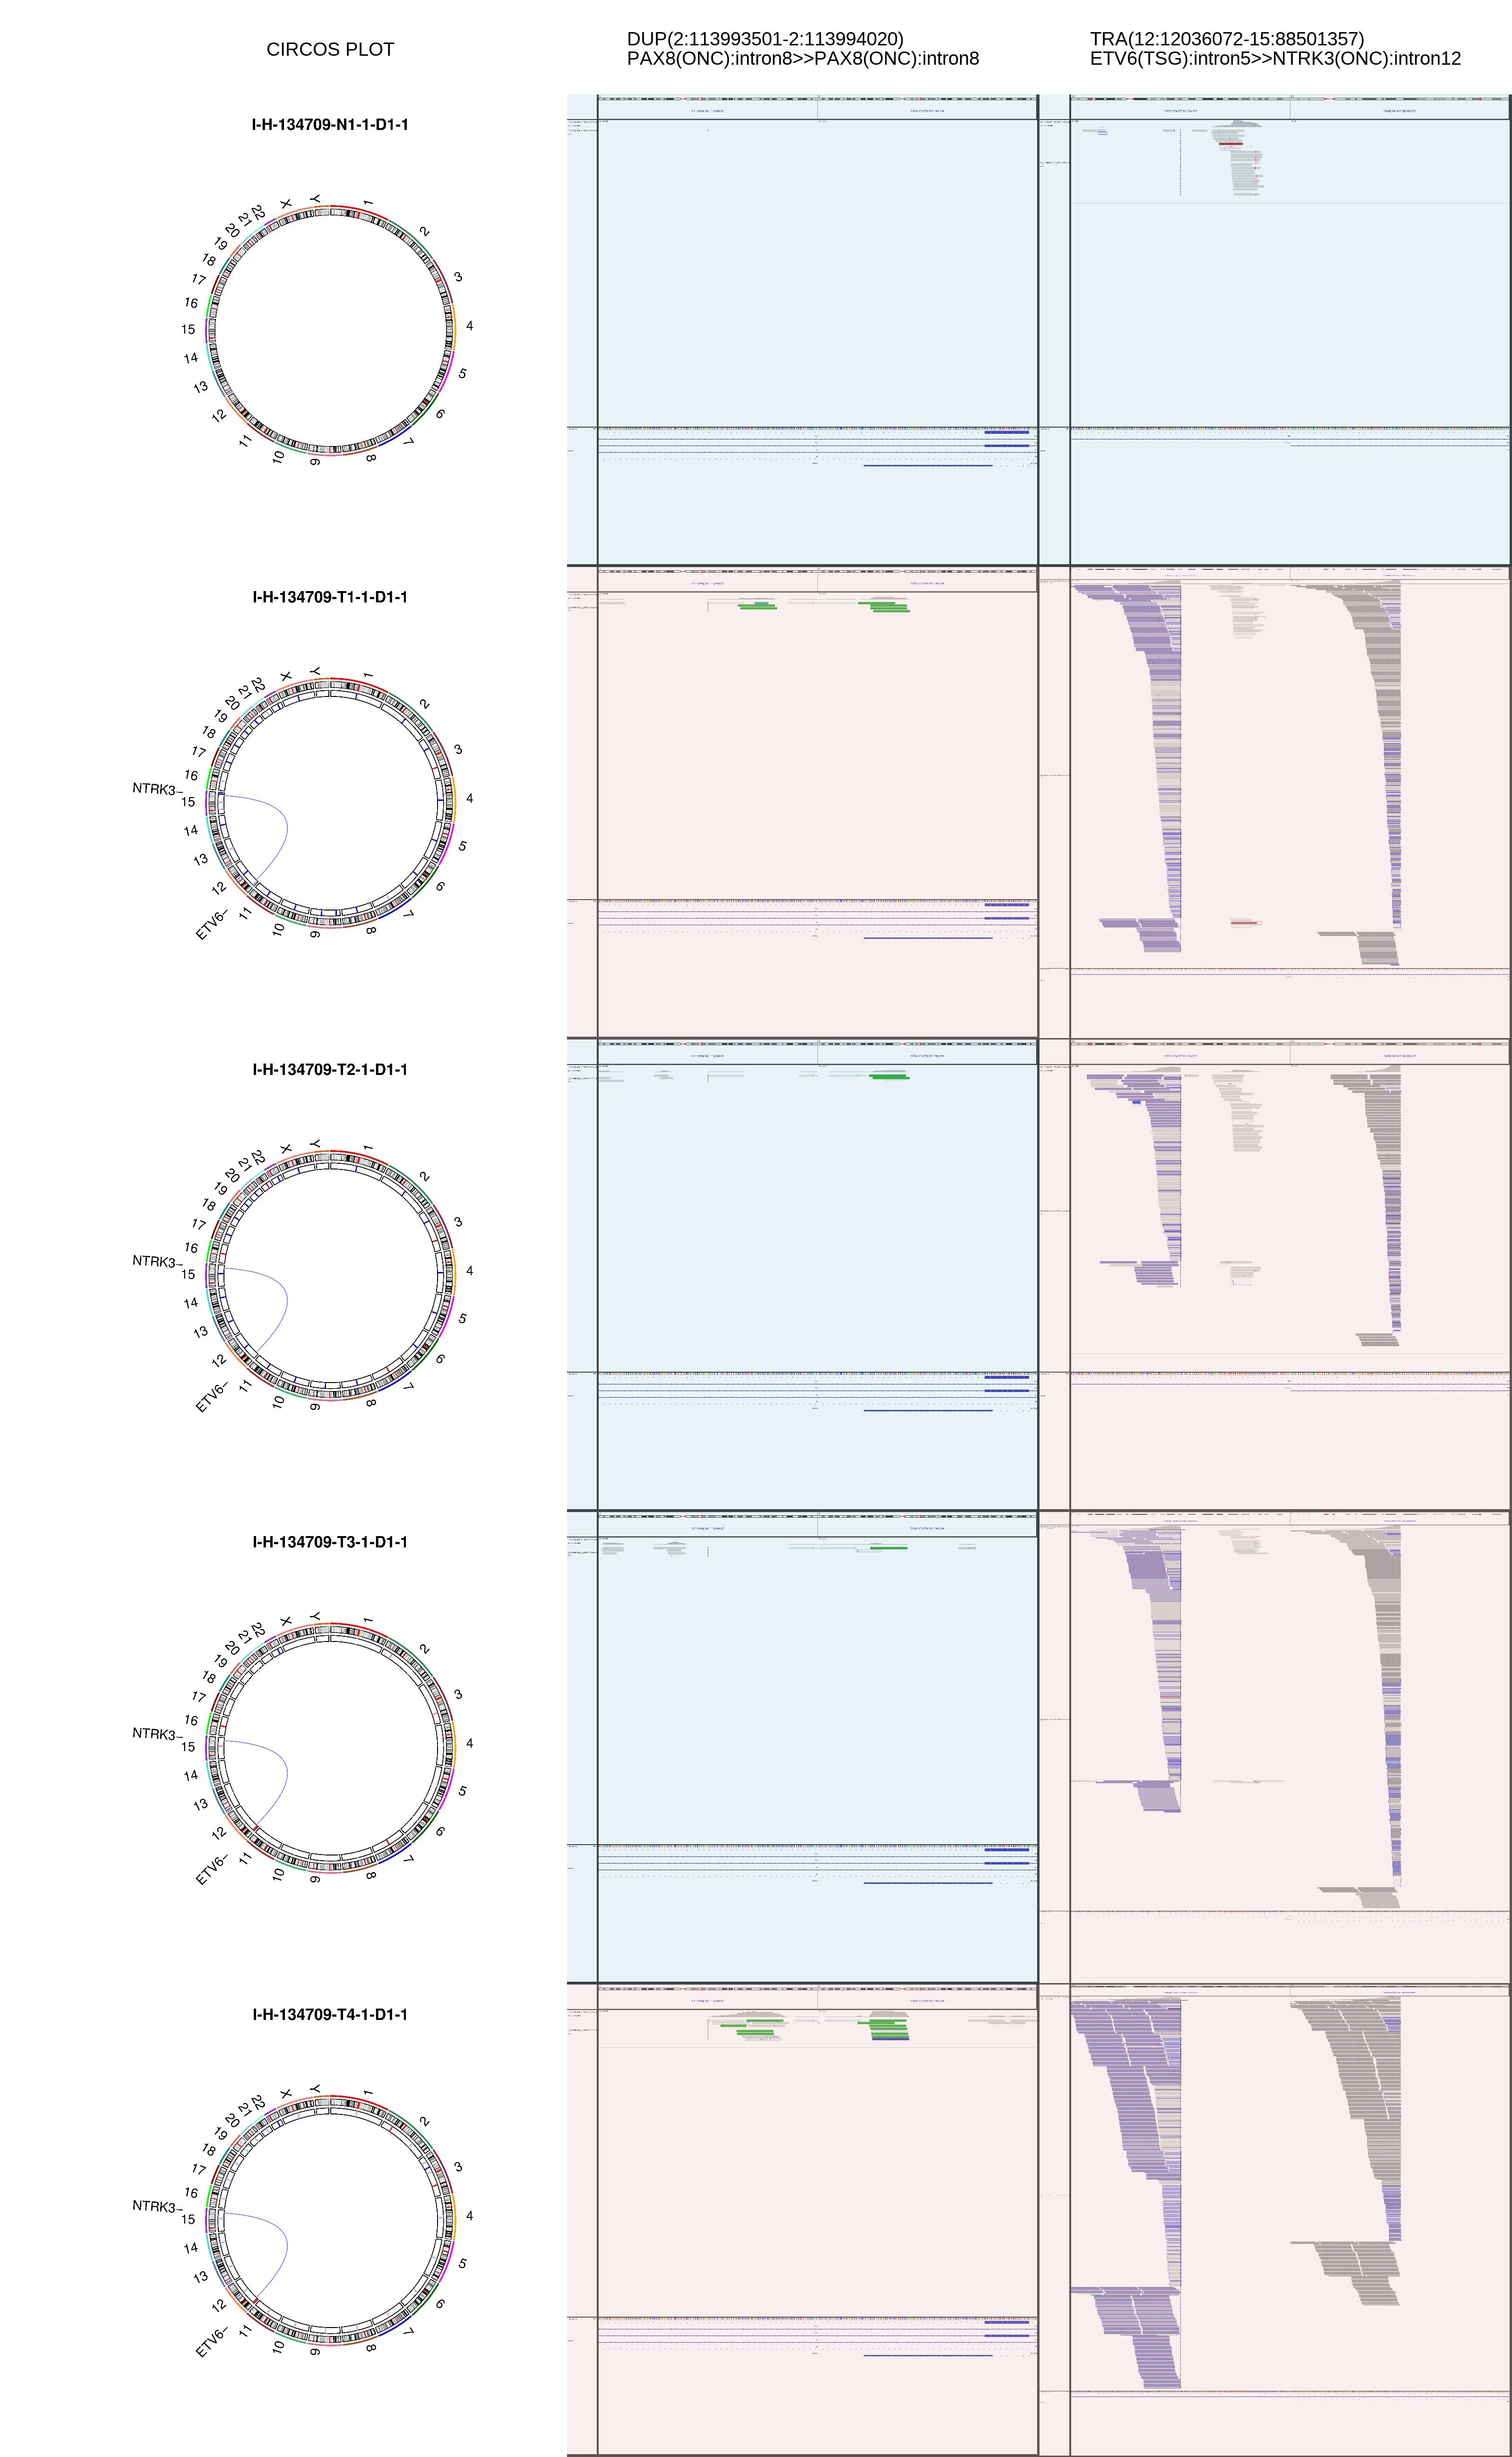

In [81]:
grid=create_imagen(outdir, samples_ids, svs, df_out_filt, df_path, dict_annotation)
grid